Assignment-2

Objective:

Build and experiment with advanced LSTM model variant for RUL prediction.

1. Imports necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional,Input
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2. Data Loading

In [2]:
X=np.load('rolling_window_sequences.npy')
metadata = pd.read_csv("C:/Users/Admin/Downloads/sequence_metadata_with_RUL.csv")
y=metadata['RUL'].values

print(X.shape)
print(y.shape)

(17631, 30, 66)
(17631,)


3. Train/Validation Split

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


4. Define Model Architectures

In [4]:
def build_bilstm(input_shape, lstm_units=64, dropout=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout),
        Dense(1)
    ])
    return model

5. Instantiate and compile models

In [5]:
models = {
    "BiLSTM": build_bilstm((X.shape[1], X.shape[2]))
}
for name, model in models.items():
    model.compile(optimizer="adam", loss="mse")
    print(f"\n{name} Summary:")
    model.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



BiLSTM Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 128)                 │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

6. Prepare datasets for training

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

7. Setup callbacks

In [8]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
]


8. Train and compare models

In [18]:
# Train the BiLSTM model
history_bilstm = models["BiLSTM"].fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 44.0683 - val_loss: 9.5815 - learning_rate: 1.5625e-05
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 42.8070 - val_loss: 9.2469 - learning_rate: 1.5625e-05
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 43.3112 - val_loss: 9.5173 - learning_rate: 1.5625e-05
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 43.5884 - val_loss: 9.7739 - learning_rate: 1.5625e-05
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 43.9772 - val_loss: 9.4150 - learning_rate: 1.5625e-05
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 42.6015
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-05.
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 42.5164 - val_loss: 9.5460 - learning_rate: 1.5625e-05
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 42.4288 - val_loss: 9.3965 - learning_rate: 1.0000e-05


9. Plot training and validation loss curve function

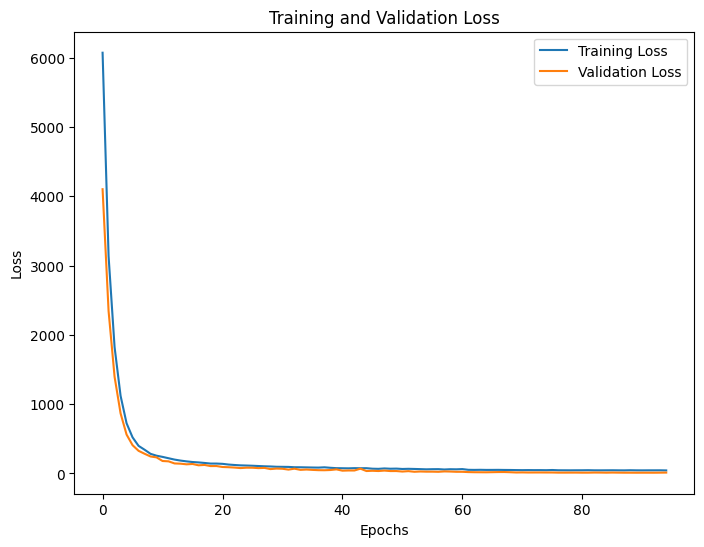

In [12]:
plt.figure(figsize=(8,6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


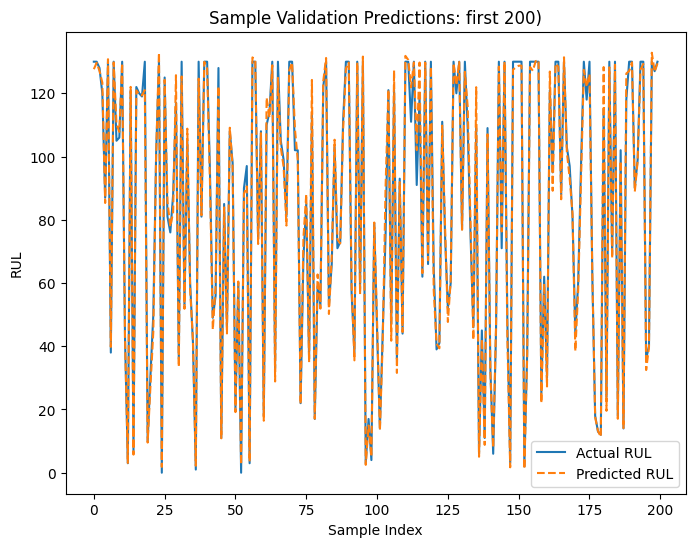

In [14]:
val_pred = models["BiLSTM"].predict(X_val[:200]).flatten()
plt.figure(figsize=(8,6))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions: first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()


10. Provide Final Report of this Experiement.

--> The Bidirectional LSTM serves as an effective baseline for predicting RUL from sequential sensor data. 

--> The training setup incorporates suitable callbacks and an appropriate loss metric.

--> Loss curves for training and validation were plotted to evaluate learning behavior and overfitting.

--> Predictions versus actual RUL for the first 200 validation samples were visualized to evaluate the model accuracy.